# Global Budget Spending Analysis
----
<i> Project 1 Team 5 </i><br/> 
Brett Fuller, Diego Jones, Mav Sanchez

In [1]:
#Import necessary package dependencies
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import pycountry

from pprint import pprint
from scipy.stats import linregress

#Import API Key
from config import *

#Define directories
source_data_dir = "source_data"
staging_data_dir = "staging_data"
target_data_dir = "target_data"
target_images_dir = "target_images"

### Functions declaration
----
#####            To be re-used for downstream cells

In [35]:
#Standardize country names
def get_country_name(isocode3):
    try:
        if len(isocode3) == 3:
            return pycountry.countries.get(alpha_3=isocode3).name
        elif len(isocode3) == 2:
            return pycountry.countries.get(alpha_2=isocode3).name
    except:
        return None

# Plotters
def scatter_plotter(df, x='None', y='None'):
    try: 
        x_axis = df[x]
        y_axis = df[y]
        plt.title(f"{x} vs {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.scatter(x_axis, y_axis, marker='o', facecolors="steelblue", edgecolors="black", alpha=0.75)
        plt.grid()
        plt.show()
        print('Plotting successful.')
    except:
        print('Plotting unsuccessful. Please review parameters and ensure correct column name is passed')

def line_plotter(df, x_param, y_param, color_param):
    try:
        df.plot(x=x_param,y=y_param,label=y_param,color=color_param,marker='o',linestyle="solid", linewidth=0.75,ms=4)
        plt.xlabel(x_param)
        plt.ylabel(y_param)
        plt.title(f"{y_param} over {x_param}")
        plt.legend(loc='best')
        plt.grid()
    except:
        print('Plotting unsuccessful. Please review parameters and ensure correct column name is passed')

def linreg_plotter(df, x='None', y='None'):
    try: 
        # The plt clf will CLear out the Figure settings, for reusability
        plt.clf()
        x_values = df[x]
        y_values = df[y]

        # Calculation of linear regression given x and y values
        slope, intercept, rvalue, pvalue, stderr = linregress(x_values, y_values)
        regression_values = x_values * slope + intercept
        line_eq = f"y = {round(slope, 2)}x + {round(intercept,2)}"
        print(f"The r-squared (absolute) is :{abs(rvalue)}\n")

        #Plot proper
        plt.scatter(x_values, y_values, facecolors="steelblue")
        plt.plot(x_values, regression_values, 'r-')
        plt.annotate(line_eq, (min(x_values)+5, min(y_values)+5), fontsize=15, color="red")

        plt.title(f"{x} vs {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        #plt.savefig(f"output_data/LinReg_Latitude_Vs_{factor}_{where.title()}.png")
        plt.show()
        print('Plotting successful.')
    except:
        print('Plotting unsuccessful. Please review parameters and ensure correct column name is passed')

def pie_plotter(df, x, y, title):
    try:
        fig, ax = plt.subplots(figsize=(8, 8))
        data = list(df[x])
        ax.pie(data, startangle=90,  labels=df[y], autopct='%1.1f%%', textprops={'fontsize': 10})
        fig.set_facecolor('white')
        ax.set_title(title)
        plt.show()
        print('Plotting successful.')
    except:
        print('Plotting unsuccessful. Please review parameters and ensure correct column name is passed')
        
        
# API functions        
def call_worldbank(indicator_wb, years_wb):
    try:
        #World Bank
        api_format_wb = "json"
        # Get the list of Government expenditure on education, total (% of GDP)
        response = requests.get(f"{base_url_worldbank}{indicator_wb}?format={api_format_wb}&date={years_wb}").json()
        observation_size = response[0]['total']
        
        wb_response = requests.get(f"{base_url_worldbank}{indicator_wb}?format={api_format_wb}&date={years_wb}&per_page={observation_size}").json()
        wb_data_df = pd.DataFrame(wb_response[1])
        print('API Call to World Bank succeeded')  
        return wb_data_df
    except:
        print('API Call to WorldBank failed')
        
def call_imf(spending_area, year_start, year_end):
    try:
        FREQ="A"
        REF_AREA=spending_area
        REF_SECTOR="S13"
        UNIT_MEASURE="XDC_R_OTE"
        COFOG_FUNCTION=""
        START_YEAR=year_start
        END_YEAR=year_end
        query_url_imf=f"http://dataservices.imf.org/REST/SDMX_JSON.svc/CompactData/GFSCOFOG/{FREQ}.{REF_AREA}.{REF_SECTOR}.{UNIT_MEASURE}.{COFOG_FUNCTION}?startPeriod={START_YEAR}&endPeriod={END_YEAR}"
        response = requests.get(f"{query_url_imf}").json()
        print('API Call to IMF succeeded')  
        return response
    except:
        print('API Call to IMF failed')  
        
def call_oecd(indicator_wb, years_wb):
    try:
        # Get the list of Government expenditure on education, total (% of GDP)
        response = requests.get(f"{base_url_worldbank}{indicator_wb}?format={api_format_wb}&date={years_wb}").json()
        observation_size = response[0]['total']
        
        wb_response = requests.get(f"{base_url_worldbank}{indicator_wb}?format={api_format_wb}&date={years_wb}&per_page={observation_size}").json()
        wb_data_df = pd.DataFrame(wb_response[1])
        print('API Call to OECD succeeded')  
        return wb_data_df
    except:
        print('API Call to OECD failed')   

### Data extraction
----
#####            API Calls

In [3]:
# Define base URLs for API
base_url_oecd ="https://stats.oecd.org/SDMX-JSON/data/"
base_url_worldbank = "http://api.worldbank.org/v2/country/all/indicator/"

In [4]:
# Get the list of Government expenditure on education, total (% of GDP)
wb_data_df = call_worldbank("SE.XPD.TOTL.GD.ZS", "2000:2019") # Government expenditure on education, total (% of GDP)
wb_data_df.drop(columns=['indicator', 'country', 'unit', 'obs_status', 'decimal'], axis=1, inplace=True)
wb_data_df.rename(columns={'countryiso3code':'Country','date':'Year', 'value': 'Percent GDP Spent'}, inplace=True)
wb_data_df.Year = wb_data_df.Year.astype('int64')
wb_data_df['Country'] = wb_data_df['Country'].apply(lambda x: get_country_name(x))
wb_data_df.dropna(inplace=True)

# Get the list of Government expenditure on education, total (% of GDP)
wb_data_per_student_df = call_worldbank("SE.XPD.PRIM.PC.ZS", "2000:2019") # GDP Capita Per Student
wb_data_per_student_df.drop(columns=['indicator', 'country', 'unit', 'obs_status', 'decimal'], axis=1, inplace=True)
wb_data_per_student_df.rename(columns={'countryiso3code':'Country','date':'Year', 'value': 'Per Student Spending'}, inplace=True)
wb_data_per_student_df.Year = wb_data_per_student_df.Year.astype('int64')
wb_data_per_student_df['Country'] = wb_data_per_student_df['Country'].apply(lambda x: get_country_name(x))
wb_data_per_student_df.dropna(inplace=True)

API Call to World Bank succeeded
API Call to World Bank succeeded


In [5]:
wb_data_df.head()

,Country,Year,Percent GDP Spent
942,Afghanistan,2017,4.05887
943,Afghanistan,2016,4.22836
944,Afghanistan,2015,3.25580
945,Afghanistan,2014,3.69522
946,Afghanistan,2013,3.45446


In [6]:
wb_data_per_student_df.head()

,Country,Year,Per Student Spending
942,Afghanistan,2017,10.02208
944,Afghanistan,2015,8.32950
945,Afghanistan,2014,9.65715
946,Afghanistan,2013,9.25884
947,Afghanistan,2012,7.34472


#####            CSV Load

In [7]:
# Load raw CSV files to data frame
pisa_science = pd.read_csv(f"{source_data_dir}/pisa_science_2006_2015.csv")
pisa_math = pd.read_csv(f"{source_data_dir}/pisa_math_2003_2015.csv")
pisa_reading  = pd.read_csv(f"{source_data_dir}/pisa_read_2000_2015.csv")

### Data cleansing
----

In [8]:
# Only pull data older than 2006
pisa_reading = pisa_reading.loc[pisa_reading['TIME']>=2006,['LOCATION','INDICATOR', 'TIME','Value'] ]
pisa_math = pisa_math.loc[pisa_math['TIME']>=2006,['LOCATION','INDICATOR', 'TIME','Value']]
pisa_science = pisa_science.loc[pisa_science['TIME']>=2006,['LOCATION','INDICATOR', 'TIME','Value']]

#Merge all Reading, Math, Science data
pisa_merged = pisa_reading.merge(pisa_math, how="inner", on=['LOCATION', 'TIME'], suffixes=('_READING', '_MATH'))
pisa_merged = pisa_merged.merge(pisa_science, how="inner", on=['LOCATION', 'TIME'], suffixes=('','_SCIENCE'))
pisa_merged = pisa_merged[['LOCATION','TIME', 'Value_READING','Value_MATH', 'Value']]

# Rename columns and create a new column, 'Average Students Score', to calculate mean score among all subjects (PISA-standard)
pisa_merged = pisa_merged.rename(columns={'LOCATION' : 'Country','TIME': 'Year', 'Value_READING':'Reading','Value_MATH':'Math', 'Value':'Science'})
pisa_merged['Average Students Score'] = pisa_merged[['Reading','Math','Science']].mean(axis=1).round(2)

# Transform ISO3 codes countries to their corresponding pycountry name
pisa_merged['Country'] = pisa_merged['Country'].apply(lambda x: get_country_name(x))
pisa_merged.dropna()
pisa_merged.head()

,Country,Year,Reading,Math,Science,Average Students Score
0,Australia,2006,513,520,527,520.00
1,Australia,2009,515,514,527,518.67
2,Australia,2012,512,504,521,512.33
3,Australia,2015,503,494,510,502.33
4,Austria,2006,490,505,511,502.00


### Data analysis
----

#### Question 2: What is the education budget allocation effect on students' academic performance?
Data sources: 
- OECD PISA Result<br/>
- OECD Government budget allocation<br/>

In [9]:
# Merge PISA data and WorldBank data
wb_pisa_merged_df = pisa_merged.merge(wb_data_df, how="inner", on=['Country', 'Year'])
wb_pisa_merged_df.head()

,Country,Year,Reading,Math,Science,Average Students Score,Percent GDP Spent
0,Australia,2006,513,520,527,520.00,4.75359
1,Australia,2009,515,514,527,518.67,5.09327
2,Australia,2012,512,504,521,512.33,4.87765
3,Australia,2015,503,494,510,502.33,5.32175
4,Austria,2006,490,505,511,502.00,5.22652


---
#### The plot below shows a positive correlation between countries' expenditure on education on all levels and the students' performance on OECD Programme for International Student Assessment. The r-value between the correlation is 0.24. Countries with higher GDP expense allocated to education tends to score higher on Reading, Math, and Science. With the data set pulled from United Nations and World bank ranging from 2000 to 2019, it can be said that there is a causal relationship between education spending and students' performance.
---

The r-squared (absolute) is :0.2362212780270634



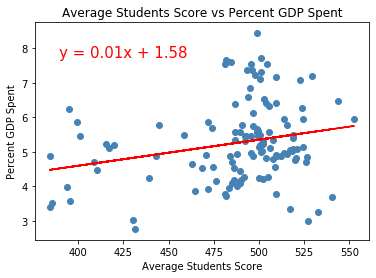

Plotting successful.


In [10]:
linreg_plotter(wb_pisa_merged_df, 'Average Students Score', 'Percent GDP Spent')

In [11]:
# Merge PISA data and WorldBank data
wb_pisa_ps_merged_df = pisa_merged.merge(wb_data_per_student_df, how="inner", on=['Country', 'Year'])
wb_pisa_ps_merged_df.head()

,Country,Year,Reading,Math,Science,Average Students Score,Per Student Spending
0,Australia,2006,513,520,527,520.00,17.74496
1,Australia,2009,515,514,527,518.67,19.94908
2,Australia,2012,512,504,521,512.33,18.17317
3,Australia,2015,503,494,510,502.33,18.81944
4,Austria,2006,490,505,511,502.00,22.58595


---
#### Although national GDP varies country to country and depends on economic standings, we pulled the GDP Per Capita (GDP % Population) and also saw a positive correlation between the mean students' score and GDP Per Student spending. Note that the OECD Data of "per student spending" is the 'average general government expenditure (current, capital, and transfers) per student in the given level of education, expressed as a percentage of GDP per capita.'. 
---

The r-squared (absolute) is :0.3672940012232876



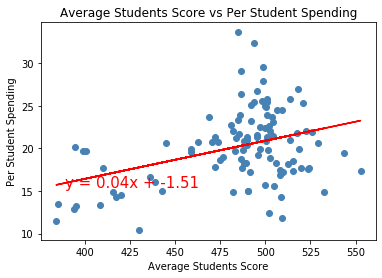

Plotting successful.


In [12]:
linreg_plotter(wb_pisa_ps_merged_df, 'Average Students Score', 'Per Student Spending')

#### Question 3: What are the possible Government Expenses that can be linked to CO2 emmissions? 
Data sources: <br/>
- <b> WorldBank Total greenhouse gas emissions </b> in kt of CO2 equivalent are composed of CO2 totals excluding short-cycle biomass burning (such as agricultural waste burning and Savannah burning) but including other biomass burning (such as forest fires, post-burn decay, peat fires and decay of drained peatlands), all anthropogenic CH4 sources, N2O sources and F-gases (HFCs, PFCs and SF6). <br/>
- IMF API Government Finance Statistics (GFS), Expenditure by Function of Government (COFOG)

In [13]:
# Call CO2 API from World Bank
wb_co2_emissions_df = call_worldbank("EN.ATM.CO2E.KT","2000:2019")
wb_co2_emissions_df.drop(columns=['indicator', 'country', 'unit', 'obs_status', 'decimal'], axis=1, inplace=True)
wb_co2_emissions_df.rename(columns={'countryiso3code':'Country','date':'Year', 'value': 'CO2 Emissions (Kilo Ton)'}, inplace=True)
wb_co2_emissions_df.Year = wb_co2_emissions_df.Year.astype('int64')
wb_co2_emissions_df['Country'] = wb_co2_emissions_df['Country'].apply(lambda x: get_country_name(x))
wb_co2_emissions_df.dropna(inplace=True)
wb_co2_emissions_df.head()

API Call to World Bank succeeded


,Country,Year,CO2 Emissions (Kilo Ton)
945,Afghanistan,2014,9809.225
946,Afghanistan,2013,10014.577
947,Afghanistan,2012,10755.311
948,Afghanistan,2011,12240.446
949,Afghanistan,2010,8463.436


In [14]:
# Call IMF API Government Finance Statistics (GFS), Expenditure by Function of Government (COFOG) from 2000 to 2016
imf_response = call_imf("", 2000, 2019)
imf_df = pd.DataFrame(imf_response['CompactData']['DataSet']['Series'])
imf_raw_df = pd.DataFrame({ 'Country' : imf_df['@REF_AREA'], 'Area' : imf_df['@COFOG_FUNCTION'],'Obs' : imf_df['Obs'] })
imf_raw_df = imf_raw_df.dropna()

# Create a Data frame from response
country = []
expense_type = []
year = []
value = []
for index, row in imf_raw_df.iterrows(): 
    for i in row['Obs']:
        try:
            value.append(i['@OBS_VALUE'])
            country.append(row['Country'])
            expense_type.append(row['Area'])
            year.append(i['@TIME_PERIOD'])
        except:
            pass

API Call to IMF succeeded


In [15]:
# Create Data Frame from the curated data
imf_gov_expenses_df = pd.DataFrame({
    'Country' : country ,
    'Government Function' : expense_type,
    'Year' : year,
    'Percent of GDP Expense' : value
})

# Perform data clean up. Standardize Year data type to int, use pycountry to get country name, drop nulls
imf_gov_expenses_df.Year = imf_gov_expenses_df.Year.astype('int64')
imf_gov_expenses_df['Percent of GDP Expense'] = imf_gov_expenses_df['Percent of GDP Expense'].astype('float')
imf_gov_expenses_df['Country'] = imf_gov_expenses_df['Country'].apply(lambda x: get_country_name(x))
imf_gov_expenses_df = imf_gov_expenses_df.dropna()
imf_gov_expenses_df.head()

,Country,Government Function,Year,Percent of GDP Expense
0,United Arab Emirates,GF01,2011,44.564890
1,United Arab Emirates,GF01,2012,41.933173
2,United Arab Emirates,GF01,2013,47.822993
3,United Arab Emirates,GF01,2014,49.104476
4,United Arab Emirates,GF01,2015,40.835322


In [16]:
# # ONE TIME ONLY - DO NOT REMOVE Data available in staging_data folder
# # Pulls all the codes from IMF
# get_data_struct_imf="http://dataservices.imf.org/REST/SDMX_JSON.svc/DataStructure/GFSCOFOG"
# response = requests.get(f"{get_data_struct_imf}").json()
# dimension = []
# dimension_name = []
# item_code = []
# item_description = []
# for x in response['Structure']['CodeLists']['CodeList']:
#     for i in x['Code']:
#         dimension.append(x['@id'])
#         dimension_name.append(x['Name']['#text'])
#         item_code.append(i['@value'])
#         item_description.append(i['Description']['#text'])

# imf_cofog_codes = pd.DataFrame({
#     'Dimension Code' : dimension,
#     'Dimension Description' : dimension_name,
#     'Item Code' : item_code, 
#     'Item Description' : item_description
# })
# imf_cofog_codes.to_csv(f"{staging_data_dir}/imf_codes.csv", index=False)
imf_cofog_codes_df = pd.read_csv(f"{staging_data_dir}/imf_codes.csv")
imf_cofog_codes_df.head()

,Dimension Code,Dimension Description,Item Code,Item Description
0,CL_UNIT_MULT,Scale,0,Units
1,CL_UNIT_MULT,Scale,2,Hundreds
2,CL_UNIT_MULT,Scale,3,Thousands
3,CL_UNIT_MULT,Scale,6,Millions
4,CL_UNIT_MULT,Scale,9,Billions


In [17]:
# Merge with the Codes PD to get the description type
imf_gov_expenses_clean_df = imf_gov_expenses_df.merge(imf_cofog_codes_df, how="inner", left_on='Government Function', right_on='Item Code')[['Country', 'Item Description', 'Year', 'Percent of GDP Expense']]

#Pivot Data
imf_gov_expenses_pivot_df = pd.pivot_table(imf_gov_expenses_clean_df, values = 'Percent of GDP Expense', index=['Country','Year'], columns = 'Item Description').reset_index()
imf_gov_expenses_pivot_df.head()

Item Description,Country,Year,Expenditure on defense,Expenditure on economic affairs,Expenditure on education,Expenditure on environment protection,Expenditure on general public services,Expenditure on health,Expenditure on housing & community amenities,Expenditure on public order & safety,"Expenditure on recreation, culture, & religion",Expenditure on social protection
0,Afghanistan,2006,6.846308,46.588004,14.559212,1.669115,10.966231,4.310958,1.615463,9.713450,0.972549,2.758762
1,Afghanistan,2007,7.735393,47.110128,10.814692,0.368395,10.820965,6.155899,3.201320,9.053316,1.223244,3.516647
2,Afghanistan,2008,47.821867,14.271554,4.860586,0.155304,3.135032,2.564992,1.163164,23.618340,0.427336,1.981825
3,Afghanistan,2009,42.170636,14.383248,6.492490,0.302205,6.519453,2.999766,1.568722,23.425845,0.502629,1.635009
4,Afghanistan,2010,32.508593,17.842283,6.395580,0.135353,6.105512,3.044318,0.743802,26.374643,0.457876,6.392041


In [18]:
# Merge IMF GOSF and World Bank CO2 Data
co2_gov_expenses_merge = wb_co2_emissions_df.merge(imf_gov_expenses_pivot_df, how="inner", on=['Country', 'Year'])

#### Question 3a: First, we'll try to look at the most sensible link; the governments expenditure on environment protection.
---
#### We've included all years for all countries and made the x-axis (cause) as the expenditure, while CO2 emission is the cause. Our goal is to determine if there is a correlation on how much are the global governments spending on protecting the environment and the amount of Carbon Dioxide they produce. Plotting through Linear Regression shows that there is weak to no positive relationship at all between the two.
---

The r-squared (absolute) is :0.06742692082833593



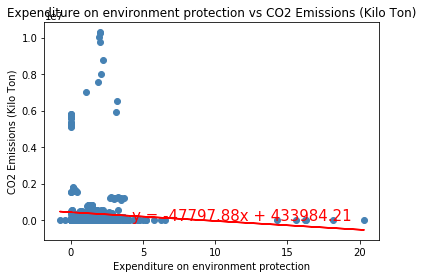

Plotting successful.


In [19]:
co2_gov_expenses_merge = co2_gov_expenses_merge.fillna(0)
linreg_plotter(co2_gov_expenses_merge, 'Expenditure on environment protection', 'CO2 Emissions (Kilo Ton)')

In [24]:
# We'll group by year and create a line plot to see trend between emmission and spending:
co2_gov_expenses_groupby_yr = co2_gov_expenses_merge.groupby(['Year']).agg({ 
                            'CO2 Emissions (Kilo Ton)': 'sum',
                            'Expenditure on environment protection': 'mean' }).reset_index()
co2_gov_expenses_groupby_yr.head()

,Year,CO2 Emissions (Kilo Ton),Expenditure on environment protection
0,2000,1.217075e+07,1.286903
1,2001,1.294732e+07,1.341897
2,2002,1.318703e+07,1.403757
3,2003,1.351533e+07,1.437973
4,2004,1.370211e+07,1.457930


---
#### We've grouped the DataFrame by year, to calculate the total annual Global Carbon Dioxide Emissions, and the total average percentage spending of all countries. Based from the graphs, it can be deduced that the lesser the world governments' spend on climate change, the more the global emmissions countries' generate. 
---

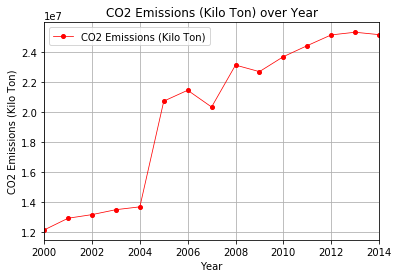

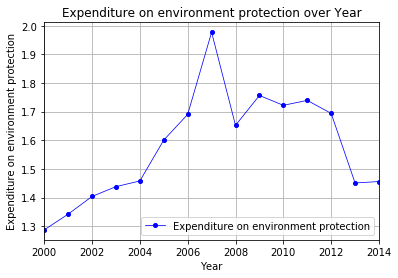

In [30]:
line_plotter(co2_gov_expenses_groupby_yr, 'Year', 'CO2 Emissions (Kilo Ton)', 'red') 
line_plotter(co2_gov_expenses_groupby_yr, 'Year', 'Expenditure on environment protection', 'blue')     

In [ ]:
#### Question 3b: Who are the world's top CO2 emitters?
---
#### After slicing the data frame to include only the top 10 CO2 producers, cumulative from year 2010 onwards, the pie chart below preents the world's largest Carbon Dioxide polluters. 
---

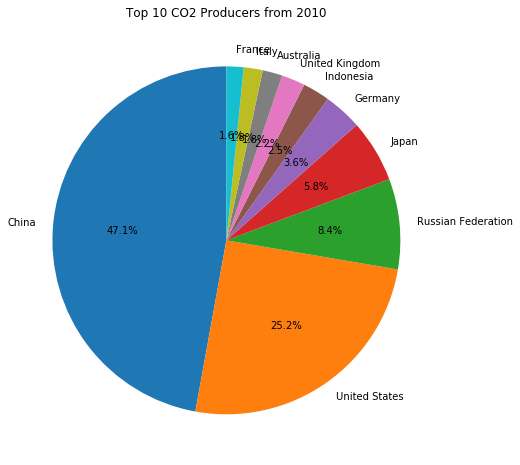

Plotting successful.


In [36]:
# Pull only from year 2010 onwards, then get the sum of CO2 emmissions by country
co2_gov_expenses_groupby_country = co2_gov_expenses_merge.loc[co2_gov_expenses_merge['Year'] >= 2010,:].groupby(['Country']).agg({ 
                            'CO2 Emissions (Kilo Ton)': 'sum'}).reset_index()
co2_top_10_polluters = co2_gov_expenses_groupby_country.sort_values(by='CO2 Emissions (Kilo Ton)', ascending=False).head(10)

pie_plotter(co2_top_10_polluters, 'CO2 Emissions (Kilo Ton)', 'Country', 'Top 10 CO2 Producers from 2010')